In [34]:
from btypes import *
from copy import deepcopy
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Mapping, Set
from algorithm import draw_graph

In [2]:
G = Graph({
    1: {2: (4, 10), 4: (15, 25)},
    2: {3: (4, 10), 4: (12, 15)},
    3: {4: (4, 10)},
    4: {}
})

In [3]:
destination = 4

G.init_tables(destination)
old_tables = original_baruah(G, destination, True)
for x, entries in old_tables.items():
    print(entries)

[Entry: 25 2 12, Entry: 25 4 15]
[Entry: 15 4 12, Entry: 20 3 8]
[Entry: 10 4 4]
[Entry: 0 None 0]


In [4]:
u = 1
v = 2
new_delay = (6, 10)

G.modify_edge(u, v, new_delay)

In [5]:
v_node = G.nodes_obj[v]
v_node.propogate([], u, [])

In [6]:
for x, node in G.nodes_obj.items():
    print(node.routing_table)

[Entry: 25 4 15, Entry: 25 2 18, Entry: 26 2 14]
[Entry: 15 4 12, Entry: 20 3 8]
[Entry: 10 4 4]
[Entry: 0 None 0]


In [7]:
new_tables = original_baruah(G, destination, True)
for x, entries in new_tables.items():
    print(entries)

[Entry: 26 2 14, Entry: 25 2 18, Entry: 25 4 15]
[Entry: 15 4 12, Entry: 20 3 8]
[Entry: 10 4 4]
[Entry: 0 None 0]


In [8]:
G.edges()

{Edge(from_node=1, to_node=4, expected_delay=15, worst_case_delay=25),
 Edge(from_node=1, to_node=2, expected_delay=6, worst_case_delay=10),
 Edge(from_node=2, to_node=4, expected_delay=12, worst_case_delay=15),
 Edge(from_node=2, to_node=3, expected_delay=4, worst_case_delay=10),
 Edge(from_node=3, to_node=4, expected_delay=4, worst_case_delay=10)}

In [9]:
def construct_tables(graph) -> Tables:
    return dict((node, node_obj.routing_table) for node, node_obj in graph.nodes_obj.items())

def difference(old_table: Table, new_table: Table) -> TableDiff:
    """
    Finds for each table the difference between old and new table.

    It returns for a table what are entries that were removed and what are entreis
    that were added to the old table to get to the new table.
    """

    old_entries = sorted(old_table.entries)
    new_entries = sorted(new_table.entries)

    # entries in old table that were removed to get to the new table
    removed: Set[Entry] = set()
    # entries in new table that were an addition to the entries of old table
    added: Set[Entry] = set()

    index_old = 0
    index_new = 0

    while(True):
        if len(old_entries) <= index_old and len(new_entries) <= index_new:
            # no more entries to consider
            break

        if len(old_entries) <= index_old:
            entry_new = new_entries[index_new]
            # entry_new only exists in the new table -> it was added
            added.add(entry_new)
            index_new += 1
            continue

        if len(new_entries) <= index_new:
            entry_old = old_entries[index_old]
            # entry_old only exist in the old table -> it was removed
            removed.add(entry_old)
            index_old += 1
            continue
        
        # at this point: index_old < len(old_table) and index_new < len(new_table) 

        entry_old = old_entries[index_old]
        entry_new = new_entries[index_new]

        if entry_old == entry_new:
            # entry exists in both tables -> not a change
            index_new += 1
            index_old += 1
            continue

        if entry_old < entry_new:
            # entry_old was "skipped over" in new table, the table is sorted -> the new table doesn't contain it -> it was removed
            removed.add(entry_old)
            index_old += 1
            continue
        
        if entry_new < entry_old:
            # entry_new was "skipped over" in old table, the table is sorted -> the old table doesn't contain it -> it was added
            added.add(entry_new)
            index_new += 1
            continue
    
    return TableDiff(removed, added)

def difference_tables(old_tables: Tables, new_tables: Tables)-> Dict[Node, TableDiff]:
    """
    Return a map, for each node return the difference.
    """
    output_differences = {}
    for (u, old_table) in old_tables.items(): 
        output_differences[u] = difference(old_table, new_tables[u])
    return output_differences


In [10]:
expected_changes = difference_tables(old_tables, new_tables)
actual_changes = difference_tables(old_tables, construct_tables(G))

In [11]:
print(expected_changes == actual_changes)

True


In [12]:
def print_tables(tables: Tables):
    for x, y in tables.items():
        print(x, y)

In [30]:
def algorithm(G: Graph, u: Node, v:Node):
    v_node = G.nodes_obj[v]
    u_node = G.nodes_obj[u]
    v_neighbors = [
        Edge(
            from_node=x.label, 
            to_node=v_node.label,
            expected_delay=expected,
            worst_case_delay=worst
        ) for x, (expected, worst) in v_node.in_going.items() if x.label != u
    ] # technically, unnecessary. Might remove it in the future 
    n = len(G.nodes_obj)
    u_node.clean(v_neighbors, v, v)
    for _ in range(n - 1):
        v_node.propogate(v_neighbors, v, []) # passing v_node to propogate does nothing.

In [14]:
def test_algorithm(name: str, graph: Graph, destination: Node, edge: Tuple[Node, Node], change: Tuple[int, int]):
    old_tables = original_baruah(graph, destination, True)
    (u, v) = edge
    old_edges = deepcopy(graph.edges())
    graph.modify_edge(u, v, change)
    algorithm(graph, u, v)
    new_tables = original_baruah(graph, destination, True)
    expected_changes = difference_tables(old_tables, new_tables)
    actual_tables = construct_tables(graph)
    actual_changes = difference_tables(old_tables, actual_tables)

    # print(f"--- {name} ---");
    # print()

    show_debug = False

    if actual_changes != expected_changes:
        print("FAIL")
        print(actual_changes)
        print(expected_changes)
        print(old_edges)
        print(edge)
        print(change)
        print("result: ")
        print_tables(actual_tables)
        print("expected: ")
        print_tables(new_tables)
        print("old tables: ")
        print_tables(old_tables)
        return 0
    return 1

In [15]:
test_algorithm("test", G, 4, (2, 3), (10, 10))

1

In [16]:
def random_test(num_tests=1000, min_nodes=5, max_nodes=15, max_delay=20):
    passes = 0
    def random_delay():
        typical = random.randint(1, max_delay-1)
        return (typical, random.randint(typical + 1, max_delay))

    for i in range(num_tests):
        nodes = [x for x in range(random.randint(min_nodes, max_nodes))] # create the nodes
        graph = dict((x, {y: random_delay()}) for x, y in zip(nodes, nodes[1:])) # turn the path into a dictionary
        n = len(nodes) # get the number of nodes
        biggest_node = n - 1
        graph[biggest_node] = {} # the last edge does not go anywhere afterwards

        for x in range(random.randint(0, n*(n-1))): # create a random number of edges. n(n-1) is the maximum number of edges
            from_node = random.randint(0, biggest_node)
            to_node = random.randint(0, biggest_node)
            while to_node == from_node: # makes sure that the to node and the from node are not the same
                to_node = random.randint(0, biggest_node)
            graph[from_node][to_node] = random_delay() # currently has an issue of accidentally overriding previous edges. But oh well.
            # graph[to_node].pop(from_node, None)
        g = Graph(graph)
        g.init_tables(biggest_node)
        from_node = random.randint(0,biggest_node) # select a random node
        while len(graph[from_node].keys()) == 0: # make sure that the node has out going edges. (might not always be the case that the node has outgoing edges)
            from_node = random.randint(0,biggest_node) # select a random node
        to_node = random.choice(list(graph[from_node].keys())) # select one of its edges
        edge = g.edge(from_node, to_node)
        new_delay = random.randint(1, edge.worst_case_delay)
        passes += test_algorithm(f"test {i}", g, biggest_node, (from_node, to_node), (new_delay, edge.worst_case_delay))
        # print(f"{passes}/{i + 1}", end="\r")
    return passes


In [17]:
G = Graph({
    0: {1: (2, 18)},
    1: {0:(1, 8), 2: (3, 18)},
    2: {},
})
G.init_tables(2)
test_algorithm("test", G, 2, (1, 2), (11, 18))

1

In [33]:
G = Graph({
    0: {3:(2, 19), 1:(12, 19)},
    1: {2:(19,20), 0:(1, 12)},
    2: {4:(7, 9), 3:(13, 15)},
    3: {0:(6, 20), 4:(17, 19), 2:(9, 12)},
    4: {2:(12, 18), 1:(7, 19)}
})
G.init_tables(4)
test_algorithm("test", G, 4, (0, 1), (5, 19))

FAIL
{0: removed: {Entry: 62 1 31, Entry: 48 1 38}, added: {Entry: 48 1 31, Entry: 55 1 25}, 1: removed: set(), added: set(), 2: removed: set(), added: set(), 3: removed: set(), added: set(), 4: removed: set(), added: set()}
{0: removed: {Entry: 62 1 31, Entry: 48 1 38}, added: {Entry: 48 1 31, Entry: 55 1 24}, 1: removed: set(), added: set(), 2: removed: set(), added: set(), 3: removed: set(), added: set(), 4: removed: set(), added: set()}
{Edge(from_node=3, to_node=0, expected_delay=6, worst_case_delay=20), Edge(from_node=2, to_node=4, expected_delay=7, worst_case_delay=9), Edge(from_node=3, to_node=4, expected_delay=17, worst_case_delay=19), Edge(from_node=0, to_node=3, expected_delay=2, worst_case_delay=19), Edge(from_node=1, to_node=2, expected_delay=19, worst_case_delay=20), Edge(from_node=4, to_node=2, expected_delay=12, worst_case_delay=18), Edge(from_node=0, to_node=1, expected_delay=12, worst_case_delay=19), Edge(from_node=3, to_node=2, expected_delay=9, worst_case_delay=12),

0

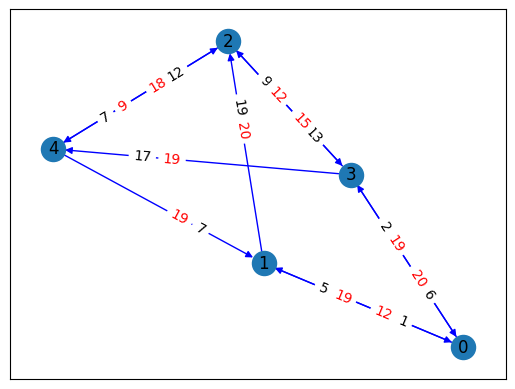

In [35]:
draw_graph(G)

In [31]:
num_tests = 1_000_000
result = random_test(num_tests=num_tests, min_nodes=5, max_nodes=5)
print(f"score: {result}/{num_tests}")

FAIL
{0: removed: {Entry: 62 1 31, Entry: 48 1 38}, added: {Entry: 48 1 31, Entry: 55 1 25}, 1: removed: set(), added: set(), 2: removed: set(), added: set(), 3: removed: set(), added: set(), 4: removed: set(), added: set()}
{0: removed: {Entry: 62 1 31, Entry: 48 1 38}, added: {Entry: 48 1 31, Entry: 55 1 24}, 1: removed: set(), added: set(), 2: removed: set(), added: set(), 3: removed: set(), added: set(), 4: removed: set(), added: set()}
{Edge(from_node=3, to_node=0, expected_delay=6, worst_case_delay=20), Edge(from_node=2, to_node=4, expected_delay=7, worst_case_delay=9), Edge(from_node=3, to_node=4, expected_delay=17, worst_case_delay=19), Edge(from_node=0, to_node=3, expected_delay=2, worst_case_delay=19), Edge(from_node=1, to_node=2, expected_delay=19, worst_case_delay=20), Edge(from_node=4, to_node=2, expected_delay=12, worst_case_delay=18), Edge(from_node=0, to_node=1, expected_delay=12, worst_case_delay=19), Edge(from_node=3, to_node=2, expected_delay=9, worst_case_delay=12),

KeyboardInterrupt: 

In [26]:
G = Graph({
    0: {1:(6, 16), 3:(1, 10)},
    1: {2:(17 ,20)},
    2: {3:(19, 20), 4:(10, 11)},
    3: {4:(2, 18), 0:(1, 13)},
    4: {}
})
G.init_tables(4)
test_algorithm("test", G, 4, (3, 4), (18, 18))

1

In [ ]:
G = Graph({
    0: {1: (2, 18)},
    1: {0:(1, 8), 2: (3, 18)},
    2: {},
})
G.init_tables(2)
test_algorithm("test", G, 2, (1, 2), (11, 18))

1

In [ ]:
G = Graph({
    0: {1: (2, 18)},
    1: {0:(1, 8), 2: (3, 18)},
    2: {},
})
G.init_tables(2)
test_algorithm("test", G, 2, (0, 1), (11, 18))

0 []
1 [Entry: 18 2 3]
2 [Entry: 0 None 0]


1

In [ ]:
G = Graph({
    0: {1: (2, 19)},
    1: {2:(15, 18)},
    2: {0: (12, 16)},
})
G.init_tables(2)
test_algorithm("test", G, 2, (0, 1), (8, 19))

FAIL
{0: removed: {Entry: 37 1 17}, added: set(), 1: removed: set(), added: set(), 2: removed: set(), added: set()}
{0: removed: {Entry: 37 1 17}, added: {Entry: 37 1 23}, 1: removed: set(), added: set(), 2: removed: set(), added: set()}
{Edge(from_node=2, to_node=0, expected_delay=12, worst_case_delay=16), Edge(from_node=1, to_node=2, expected_delay=15, worst_case_delay=18), Edge(from_node=0, to_node=1, expected_delay=2, worst_case_delay=19)}
(0, 1)
(8, 19)
result: 
0 []
1 [Entry: 18 2 15]
2 [Entry: 0 None 0]
expected: 
0 [Entry: 37 1 23]
1 [Entry: 18 2 15]
2 [Entry: 0 None 0]
old tables: 
0 [Entry: 37 1 17]
1 [Entry: 18 2 15]
2 [Entry: 0 None 0]


0